# *n*-step Bootstrapping

Normalmente ni TD ni MCM son la mejor solución, estos son los extremos de una família de métodos conocidos como *n*-step bootstrapping y soluciones intermedias suelen dar mejores resultados.

## Predicción

MCM llevan a cabo una actualización de la aproximación a la función de valor una vez termina un episodio, utilizando toda la secuencia de recompensas observadas. Por otro lado, TD utiliza la información observada en el siguiente estado. Una aproximación intermedia consiste en hacer esta actualización con más información, por ejemplo dos, tres o cuatro pasos.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/nstep.png)

En MCM la actualización de $v_\pi(S_t)$ se lleva a cabo teniendo en cuenta el retorno producido por una secuencia $S_t, R_{t+1}, S_{t+1}, ..., R_T, S_T$

\begin{equation}
    G_t = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-t-1} R_T
\end{equation}

donde $T$ es el último paso del episodio. Por otro lado, en TD hemos visto que sólo utilizamos el siguiente estado

\begin{equation}
    G_t = R_{t+1} + \gamma V_t(S_{t+1})
\end{equation}

Aplicando esta idea a un retorno en dos pasos

\begin{equation}
    G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 V_{t+1}(S_{t+2})
\end{equation}

O para una secuencia arbitraria de *n* pasos

\begin{equation}
    G_t = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1} R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n})
\end{equation}

donde $n \geq 1$ y $0 \leq t \leq T - n$. Así pues, podemos aproximar la función de valor de la siguiente manera

\begin{equation}
    V_{t+n}(S_t) = V_{t+n-1}(S_t) + \alpha [G_{t:t+n} - V_{t+n-1}(S_t)]
\end{equation}

Vamos a ver un ejemplo en el random walk.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/MRP.JPG)

In [482]:
states = 19
s = range(states)
v = [(i+1)/(states+1) for i in s]

In [559]:
import numpy as np

def nTD(episodes, alpha=0.1, n=1, gamma=1):
    V = np.ones(states+2)*0.5 
    V[0], V[states+1] = 0, 0
    history = []
    for e in range(1, episodes+1):
        S = states // 2 + 1 # empezamos en el estado central
        S0 = S
        # generate episode: S0, A0, R1, S1, A1, R2, ...
        episode = []
        fin = False
        t = 0
        G = 0
        cnt = 0
        while not fin:        
            # acción
            a = np.random.randn()
            
            # siempre derecha
            #a = 1
            
            R = 0
            # derecha
            if a > 0:
                if S == states:
                    # extremo derecho
                    R = 1
                    fin = True
                Sp = S + 1
            # izquierda
            else:
                # extremo izquierdo
                if S == 1:
                    fin = True
                Sp = S - 1
                
            # guardar step    
            episode.append((S, a, R, Sp))
            t += 1
            # update returns
            if t >= n or fin == True:
                cnt += 1
                for i, (S, _, R, _) in enumerate(episode):
                    G = 0
                    for j in range(t - i):
                        G += (gamma**j)*episode[j + i][2]
                    G += (gamma**(t-i))*V[Sp]
                    V[S] += alpha*(G - V[S])
                t = 0
                Sp = episode[0][3]
                episode = []

            # seguimos experimentando el entorno
            S = Sp

        history.append(V.copy())
    return np.array(history)

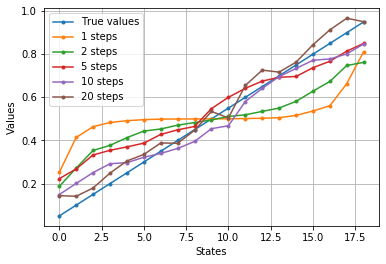

In [564]:
import matplotlib.pyplot as plt

alpha=0.1
episodes=20
plt.plot(s, v, '.-', label="True values")
for step in (1,2,5,10,20):
    plt.plot(s, nTD(episodes, alpha, step)[-1,1:-1], '.-', label=f"{step} steps")
plt.grid(True)
plt.legend()
plt.xlabel("States")
plt.ylabel("Values")
plt.show()

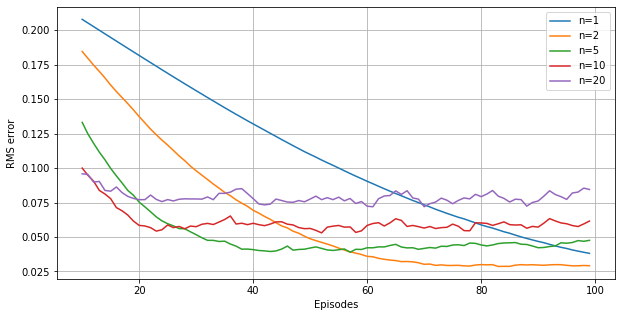

In [565]:
runs = 100
episodes = 100
alpha = 0.1
results = np.empty((runs, episodes, states))
plt.figure(figsize=(10,5))
for n in (1, 2, 5, 10, 20):
    for run in range(runs):
        results[run,:,:] = np.sqrt(np.power(nTD(episodes, alpha, n)[:,1:-1] - v, 2))
    plt.plot(range(10, episodes), results.mean(axis=0).mean(axis=1)[10:], label=fr'n={n}')
plt.grid(True)
plt.xlabel("Episodes")
plt.ylabel("RMS error")
plt.legend()
plt.show()

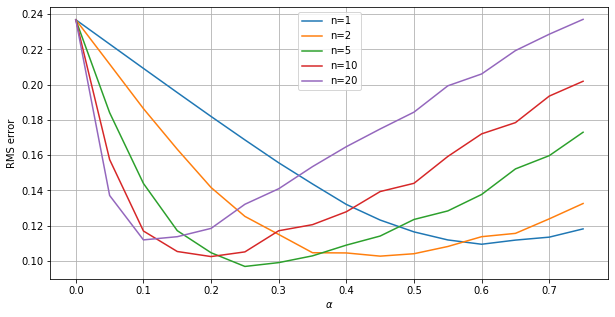

In [566]:
runs = 100
episodes = 20
alphas = np.arange(0,0.8,0.05)
plt.figure(figsize=(10,5))
for n in (1, 2, 5, 10, 20):
    results = []
    for alpha in alphas:
        result = []
        for run in range(runs):
            result.append(np.mean(np.sqrt(np.power(nTD(episodes, alpha, n)[:,1:-1] - v, 2))))
        results.append(np.mean(result))
    plt.plot(alphas, results, label=f'n={n}')
plt.grid(True)
plt.xlabel(fr"$\alpha$")
plt.ylabel("RMS error")
plt.legend()
plt.show()

## Control

- on-policy: n-step Sarsa
- off-policy: n-step Q